# Time Series Forecasting Using ARIMA Model

## 1. Introduction
This project aims to forecast future values using the ARIMA model based on historical data from the FAO pesticide dataset. The goal is to predict g/Int$ values for seven regions by historical data. In the dataset we have dataset for past 32 years, from 1990 through 2022.

## 2. Loading libraries

In [59]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 3. Data Loading and Preprocessing

In [5]:
# Load the dataset
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")

/tmp/ipykernel_43356/3919222712.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


In [6]:
# Preprocessing: Filter by 'Unit' and select relevant regions
df = df[df["Unit"] == "g/Int$"]
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
filtered_df = df[df['Area'].isin(continents_to_filter)]

## 3. Visualization of times series (1990-2021)

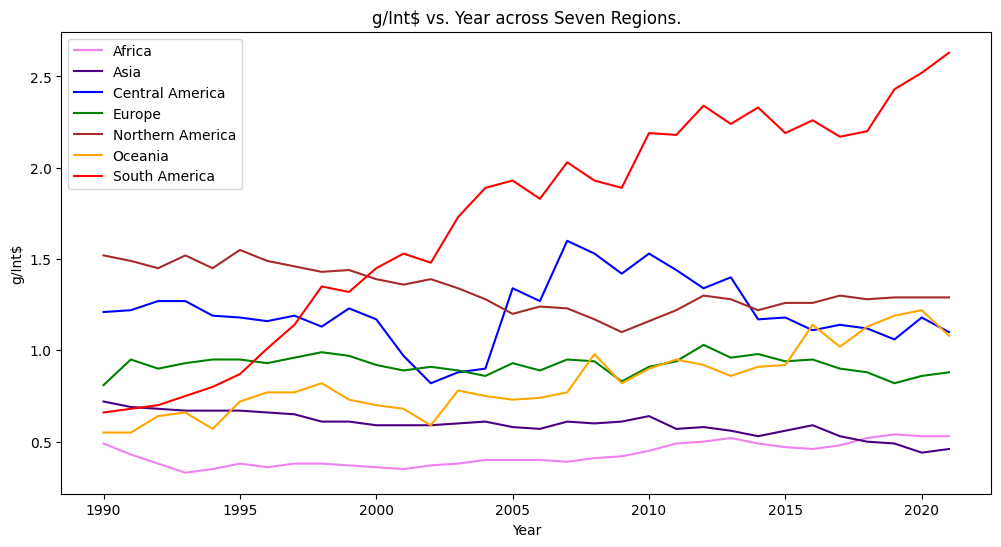

In [115]:
import matplotlib.pyplot as plt
groupedseries = filtered_df.groupby('Area')
listofdfs = [group for _, group in groupedseries]
colors = ['violet','indigo','blue','green','brown','orange','red']
plt.figure(figsize=[12,6])
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )
plt.xlabel('Year')
plt.ylabel('g/Int$')
plt.title('g/Int$ vs. Year across Seven Regions.')
plt.legend()
plt.show()

## 4. Train test split

In [21]:
def split_train_test(listofdfs, N):
    traindfs = []
    testdfs = []
    
    for df in listofdfs:
        traindfs.append(df.head(len(df) - N))  # All rows except the last N rows
        testdfs.append(df.tail(N))             # The last N rows
        
    return traindfs, testdfs

In [22]:
traindfs, testdfs = split_train_test(listofdfs, 1)
traindfs_5, testdfs_5 = split_train_test(listofdfs, 5)
traindfs_0, testdfs_0 = split_train_test(listofdfs, 0)

In [62]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    area = area.replace(" ", "")
    timeseries = traindfs[i]["Value"]
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Output/"+area+".csv")

## 5. Stationarity Check (ADF Test)

## ACF Plots Analysis for Lag Selection

For each area, the ACF plots were analyzed to choose the lags. The choice of lags discards any lags that does not cross the dotted line of threshold. These lags values were passed as maxlags parameter in the adfuller test.

In [116]:
lags = [6,3,2,0,6,4,6]

## Choice of α = 0.1

Given the time series consists of only 31 values, a more lenient alpha level of 0.1 is chosen. Smaller sample sizes typically result in lower statistical power. Increasing alpha lowers beta, thereby enhancing statistical power (1 - beta) and reducing the likelihood of failing to reject a false null hypothesis.

In the ADF test, the null hypothesis (H₀) posits that the time series is non-stationary, while the alternative hypothesis (H₁) asserts that it is stationary. We aim to minimize Type II errors—incorrectly identifying non-stationarity when the series is actually stationary. This approach ensures that we only differentiate the original time series when necessary, allowing us to select a lower \(d\) parameter in ARIMA models for regions where the time series is inherently stationary and does not require differencing.

In [86]:
alpha = 0.1

In [87]:
def runadfullertest(area, ts, lagparam, alpha):
    result = adfuller(ts, maxlag=lagparam, autolag='AIC')
    # Print the results
    print("----------------"+area+"-------------")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Number of lags used:", result[2])  # Number of lags actually used
    if result[1] < alpha:
        print("Differencing is not needed.")
    else:
        print("Differencing the timeseries is needed to make it stationary.")

In [91]:
for i in range(len(traindfs)):
    ts = traindfs[i]["Value"]
    area = traindfs[i]["Area"].unique()[0]
    runadfullertest(area, ts, lags[i], alpha)

----------------Africa-------------
ADF Statistic: 0.23661889166268463
p-value: 0.974242249220522
Number of lags used: 4
Differencing the timeseries is needed to make it stationary.
----------------Asia-------------
ADF Statistic: -0.5551230709726889
p-value: 0.8808034257898254
Number of lags used: 0
Differencing the timeseries is needed to make it stationary.
----------------Central America-------------
ADF Statistic: -2.516830491999151
p-value: 0.11143280287065666
Number of lags used: 2
Differencing the timeseries is needed to make it stationary.
----------------Europe-------------
ADF Statistic: -3.9583794320651178
p-value: 0.0016448342414842848
Number of lags used: 0
Differencing is not needed.
----------------Northern America-------------
ADF Statistic: -1.667603688479288
p-value: 0.44787654126717014
Number of lags used: 0
Differencing the timeseries is needed to make it stationary.
----------------Oceania-------------
ADF Statistic: -0.20528218211867735
p-value: 0.937889059562540

In [98]:
difneeded = [1,1,1,0,1,1,0]

In [100]:
for i in range(len(traindfs)):
    if difneeded[i] == 1:
        area = traindfs[i]["Area"].unique()[0]
        area = area.replace(" ", "")
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        data = {"y":timeseries}
        temp = pd.DataFrame(data)
        temp.to_csv("./Output_diff/"+area+".csv")

In [101]:
lags_diff = [1,6,9,-1,0,8,-1]

In [103]:
for i in range(len(traindfs)):
    if difneeded[i] == 1:
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        area = traindfs[i]["Area"].unique()[0]
        runadfullertest(area, timeseries, lags_diff[i], alpha)

----------------Africa-------------
ADF Statistic: -3.8538811518933693
p-value: 0.0024017286074033174
Number of lags used: 0
Differencing is not needed.
----------------Asia-------------
ADF Statistic: -0.9756146603880835
p-value: 0.7620540779147934
Number of lags used: 6
Differencing the timeseries is needed to make it stationary.
----------------Central America-------------
ADF Statistic: -6.0360416251733175
p-value: 1.381329524114223e-07
Number of lags used: 0
Differencing is not needed.
----------------Northern America-------------
ADF Statistic: -6.025100428768925
p-value: 1.4623187593755221e-07
Number of lags used: 0
Differencing is not needed.
----------------Oceania-------------
ADF Statistic: -8.32332309427615
p-value: 3.524414847665648e-13
Number of lags used: 0
Differencing is not needed.


In [108]:
anotherdifneeded = [0,2,0,0,0,0,0]

In [109]:
for i in range(len(traindfs)):
    if anotherdifneeded[i] == 2:
        area = traindfs[i]["Area"].unique()[0]
        area = area.replace(" ", "")
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        data = {"y":timeseries}
        temp = pd.DataFrame(data)
        temp.to_csv("./Output_diff2/"+area+".csv")

In [110]:
lags_diff2 = [-1,3,-1,-1,-1,-1,-1]

In [111]:
for i in range(len(traindfs)):
    if anotherdifneeded[i] == 2:
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        area = traindfs[i]["Area"].unique()[0]
        runadfullertest(area, timeseries, lags_diff2[i], alpha)

----------------Asia-------------
ADF Statistic: -8.579291167016484
p-value: 7.807368539923483e-14
Number of lags used: 1
Differencing is not needed.


## 6. Final choice of the d parameters

In [117]:
ds = [1,2,1,0,1,1,0]

## 7. ACF and PACF plots for choosing p and q
At this step, we will run differening ds[i] times for region[i] and plot the acf and pacf plots to choose the p and q parameters

In [119]:
def plottimeseries(data, area):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Plot ACF on the first subplot
    plot_acf(data, lags=14, ax=axes[0])  # You can change 'lags' to the number of lags you want
    axes[0].set_title('Autocorrelation Function (ACF) for ' + area)

    # Plot PACF on the second subplot
    plot_pacf(data, lags=14, ax=axes[1], method='ywm')  # 'ywm' is one of the methods; you can try 'ols' or 'ld' too
    axes[1].set_title('Partial Autocorrelation Function (PACF) for ' + area)

    # Show the plot
    plt.tight_layout()
    plt.show()

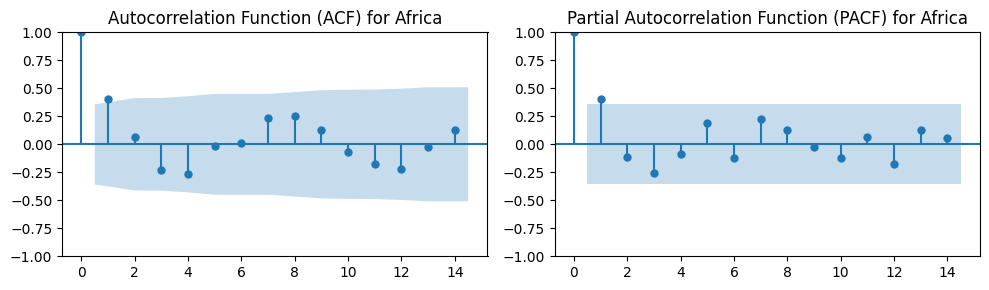

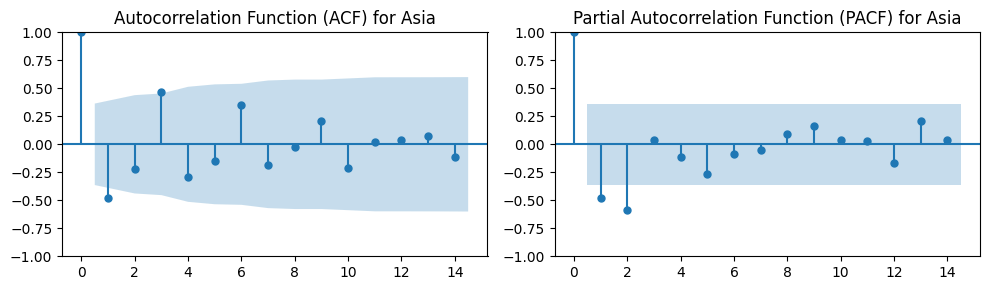

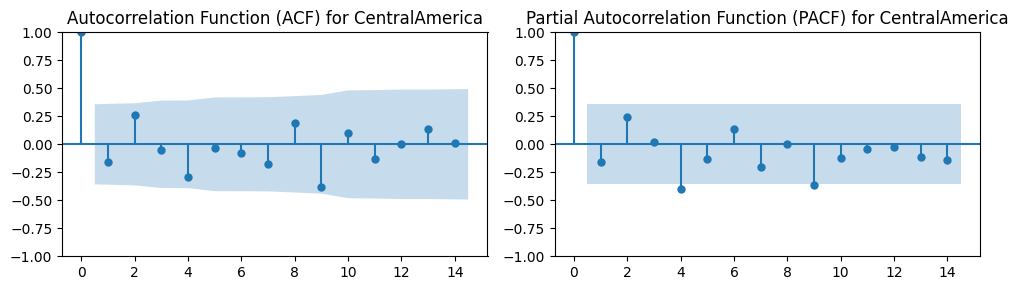

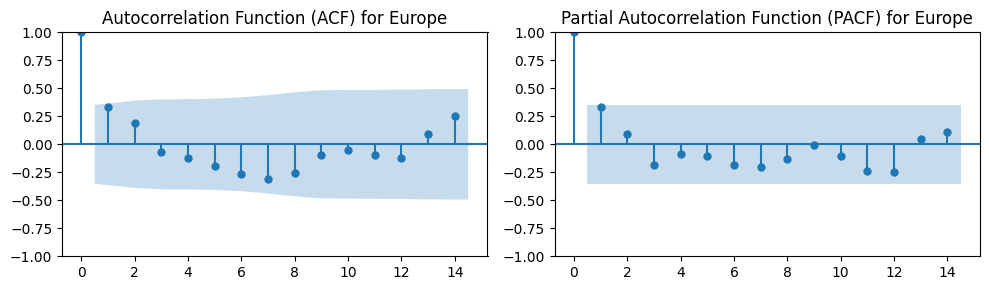

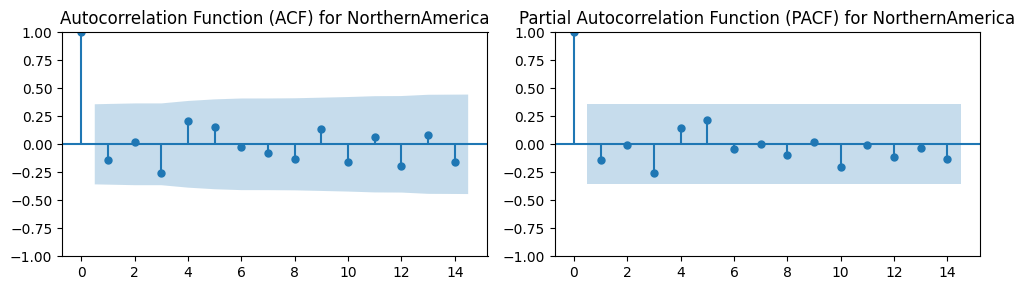

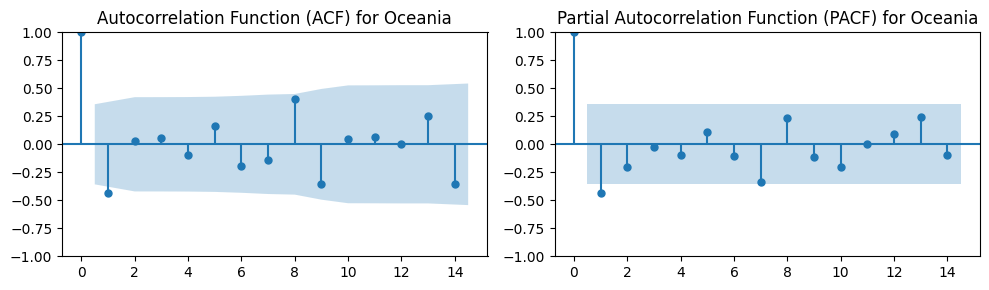

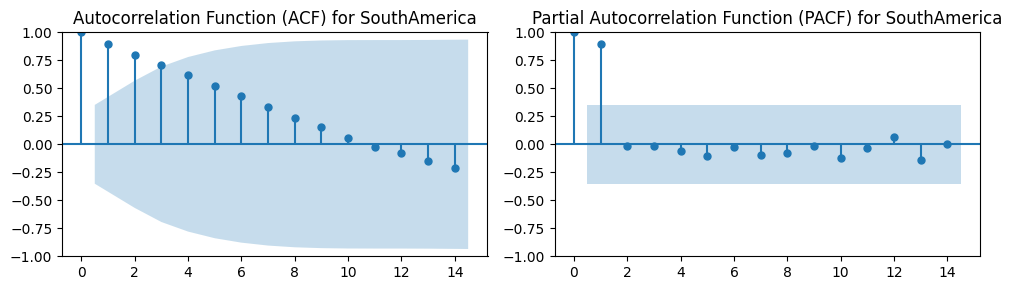

In [120]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    area = area.replace(" ", "")
    timeseries = traindfs[i]["Value"]
    x = ds[i]
    while x > 0:
        timeseries = timeseries.diff().dropna()
        x -= 1
    plottimeseries(timeseries, area)
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Output_after_d/"+area+".csv")

In [213]:
# For Europe, 1,0,1 is chosen since the first lag signficant in both the pacf and acf plots respoectively
ps = [1,2,9,1,0,1,1]
ds = [1,2,1,0,1,1,0]
qs = [1,3,9,1,0,8,6]

## 8. Forecasting

In [215]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

forecasts = []
for i in range(len(ps)):
    continent = traindfs[i]["Value"].tolist()
    model = ARIMA(continent, order = (ps[i],ds[i],qs[i]))
    model_fit = model.fit()
    continent_test = testdfs[i]["Value"]
    forecast_test = model_fit.forecast(len(continent_test))
    #print(forecast_test)
    forecasts.append(forecast_test)

## 9.Visualization of forecasts against ground truths

In [216]:
ground_truths = []
for i in range(len(testdfs)):
    ground_truths.append(testdfs[i]["Value"].tolist())

In [217]:
import matplotlib.pyplot as plt

def plot_time_series_with_forecast(original_series, ground_truth, predicted_value, area_name):

    # Create a list of years from 1990 to 2021
    years = list(range(1990, 2022))  # This will give you the years 1990 to 2021 (32 years)
    
    plt.figure(figsize=(10, 6))

    # Plot original time series (first 31 points)
    plt.plot(years[:31], original_series, label='Original Series', marker='o')

    # Plot the ground truth for the 32nd time step (year 2021)
    plt.plot(2021, ground_truth, label='Ground Truth (2021)', color='green', marker='o')

    # Plot the predicted value for the 32nd time step (year 2021)
    plt.plot(2021, predicted_value, label='Predicted (2021)', color='red', marker='x')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title(f'Time Series with Ground Truth and Prediction: {area_name}')
    plt.legend()

    # Show the plot
    plt.show()

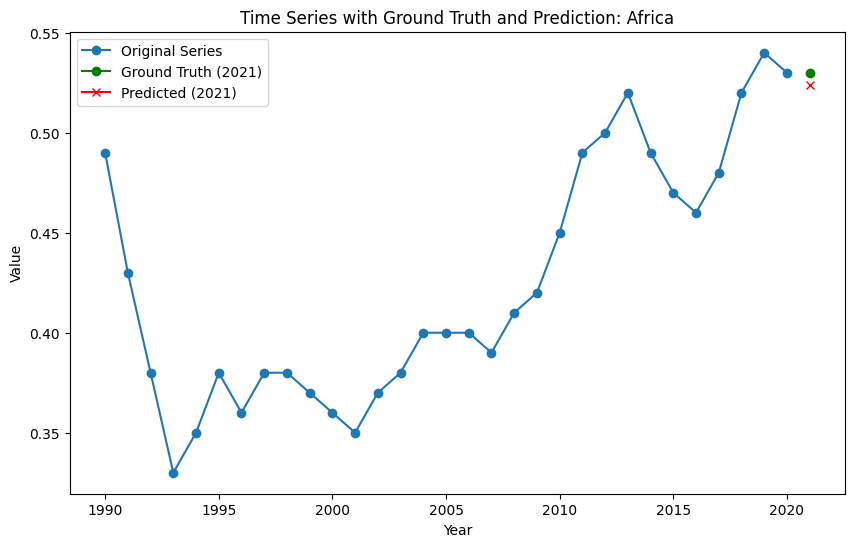

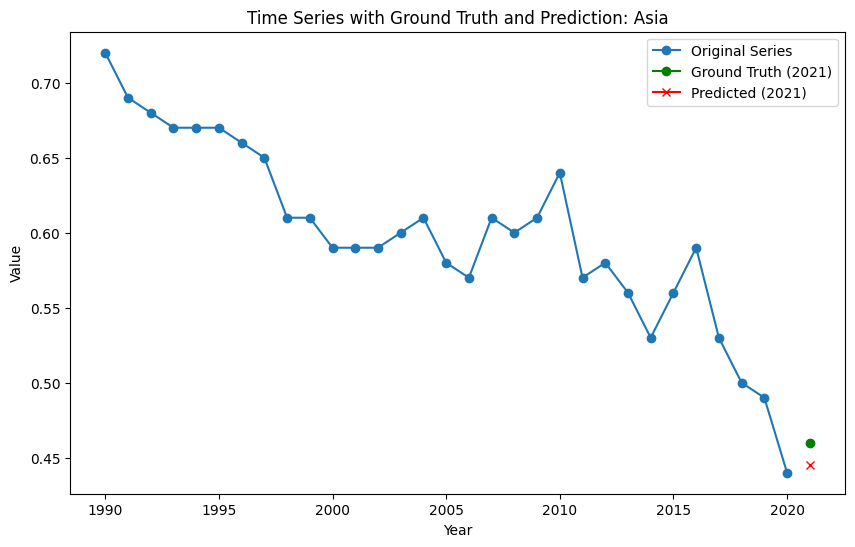

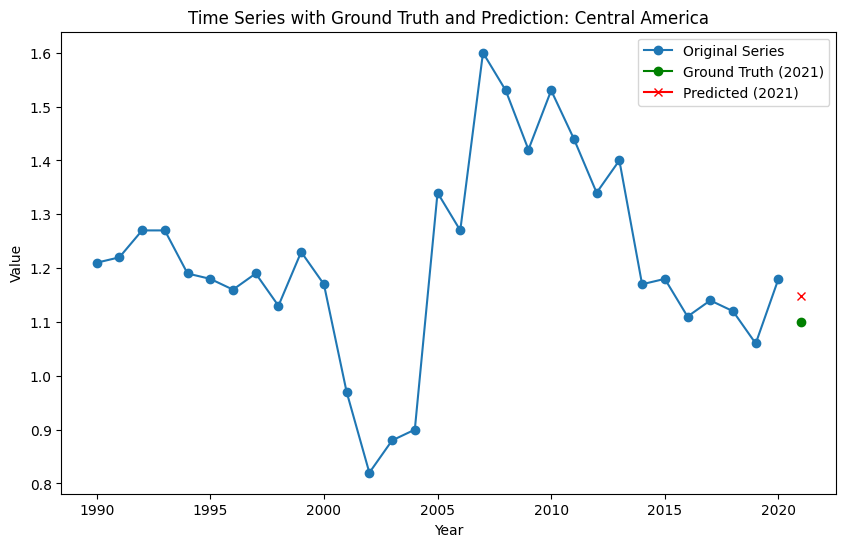

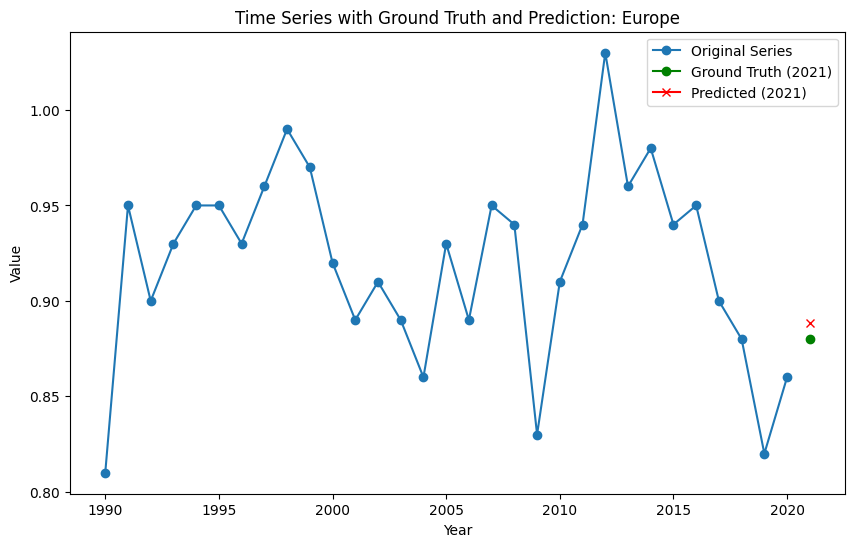

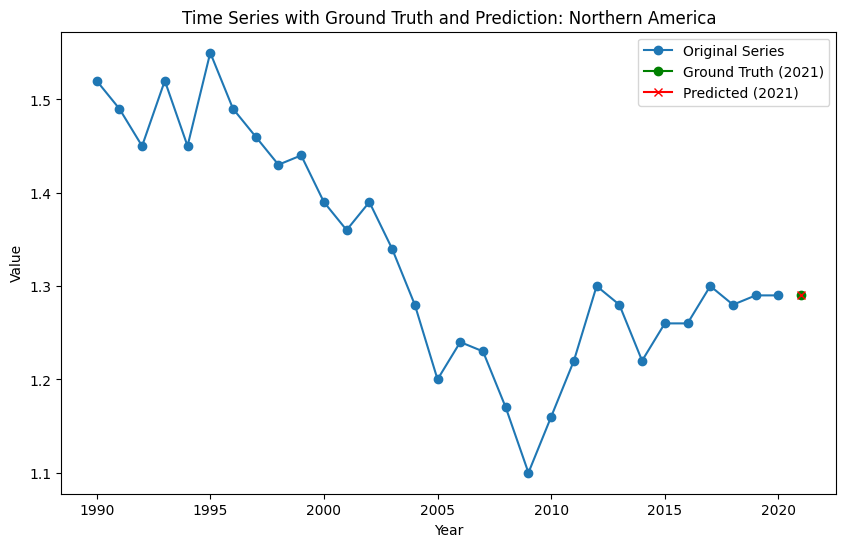

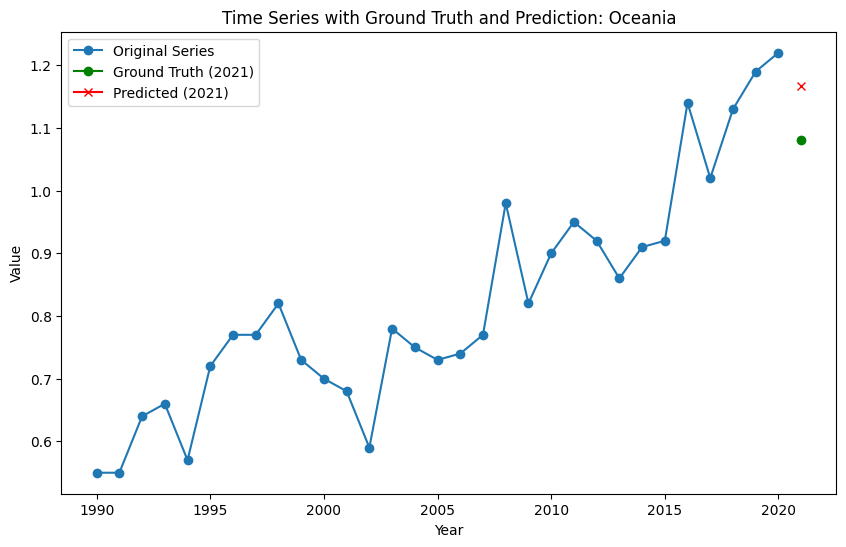

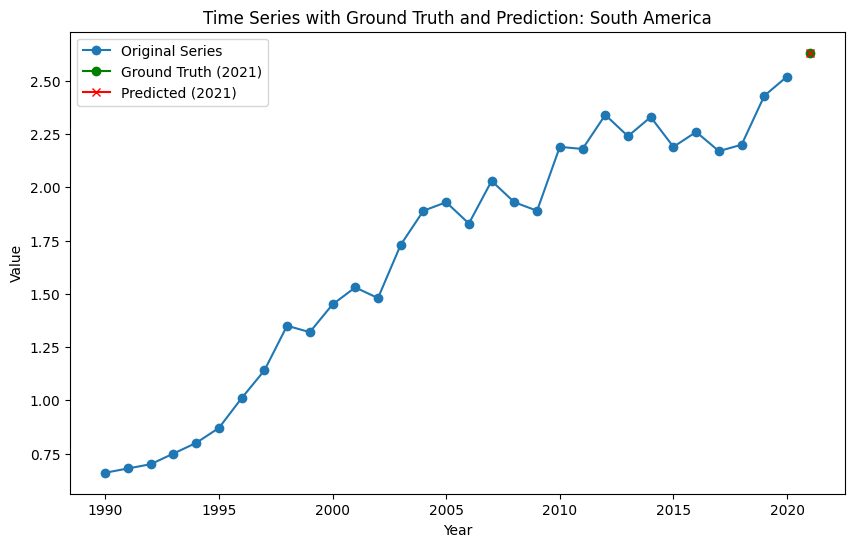

In [218]:
for i in range(len(traindfs)):
    original_series = traindfs[i]["Value"].tolist()
    ground_truth = ground_truths[i]
    predicted_value = forecasts[i]
    area = traindfs[i]["Area"].unique()[0]
    plot_time_series_with_forecast(original_series, ground_truth, predicted_value, area)

In [219]:
import pandas as pd

# Example lists (groundtruths and forecasts)
areas = ["Africa", "Asia", "Central America", "Europe", "Northern America", "Oceania", "South America"]
# Create a DataFrame using the lists
df = pd.DataFrame({
    'Area': areas,
    'Ground Truth': ground_truths,
    'Forecast': forecasts
})

# Display the DataFrame
df


,Area,Ground Truth,Forecast
0,Africa,[0.53],[0.5241053415565765]
1,Asia,[0.46],[0.44506316881332575]
2,Central America,[1.1],[1.1472885183031567]
3,Europe,[0.88],[0.8884726695106429]
4,Northern America,[1.29],[1.29]
5,Oceania,[1.08],[1.1669706216183249]
6,South America,[2.63],[2.6319333652584076]


## 10.Variant 2: Training data 27 time steps, test data 5 time steps

In [220]:
traindfs = traindfs_5
testdfs = testdfs_5

In [221]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    area = area.replace(" ", "")
    timeseries = traindfs[i]["Value"]
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Output_27/"+area+".csv")

In [223]:
# Choice of lags is the same way we did choose for the 31 time step case
lags = [3,3,2,0,5,3,5]

In [224]:
for i in range(len(traindfs)):
    ts = traindfs[i]["Value"]
    area = traindfs[i]["Area"].unique()[0]
    runadfullertest(area, ts, lags[i], alpha)

----------------Africa-------------
ADF Statistic: -1.5326497899213969
p-value: 0.5173025998485304
Number of lags used: 0
Differencing the timeseries is needed to make it stationary.
----------------Asia-------------
ADF Statistic: -2.4230152636794795
p-value: 0.13534560180735877
Number of lags used: 0
Differencing the timeseries is needed to make it stationary.
----------------Central America-------------
ADF Statistic: -2.323620101268566
p-value: 0.16446313458670975
Number of lags used: 2
Differencing the timeseries is needed to make it stationary.
----------------Europe-------------
ADF Statistic: -4.544416414749153
p-value: 0.00016332570257777078
Number of lags used: 0
Differencing is not needed.
----------------Northern America-------------
ADF Statistic: -1.4448689150442908
p-value: 0.5605865689914846
Number of lags used: 0
Differencing the timeseries is needed to make it stationary.
----------------Oceania-------------
ADF Statistic: -0.790392824865736
p-value: 0.821927826292971

In [225]:
difneeded = [1,1,1,0,1,1,1]

In [226]:
for i in range(len(traindfs)):
    if difneeded[i] == 1:
        area = traindfs[i]["Area"].unique()[0]
        area = area.replace(" ", "")
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        data = {"y":timeseries}
        temp = pd.DataFrame(data)
        temp.to_csv("./Output_27_diff/"+area+".csv")

In [228]:
# look at the acf plot to find out lags diff
lags_diff = [1,4,0,-1,0,0,7]

In [229]:
for i in range(len(traindfs)):
    if difneeded[i] == 1:
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        area = traindfs[i]["Area"].unique()[0]
        runadfullertest(area, timeseries, lags_diff[i], alpha)

----------------Africa-------------
ADF Statistic: -3.5999613757186415
p-value: 0.005761766207541843
Number of lags used: 0
Differencing is not needed.
----------------Asia-------------
ADF Statistic: -3.093015671333076
p-value: 0.027074396298296166
Number of lags used: 4
Differencing is not needed.
----------------Central America-------------
ADF Statistic: -5.546524955713936
p-value: 1.6560851516257675e-06
Number of lags used: 0
Differencing is not needed.
----------------Northern America-------------
ADF Statistic: -5.574630844778783
p-value: 1.4414501363721486e-06
Number of lags used: 0
Differencing is not needed.
----------------Oceania-------------
ADF Statistic: -6.525785385071525
p-value: 1.0154804347144277e-08
Number of lags used: 0
Differencing is not needed.
----------------South America-------------
ADF Statistic: -0.619760675241497
p-value: 0.8664541178380945
Number of lags used: 6
Differencing the timeseries is needed to make it stationary.


In [230]:
anotherdifneeded = [0,0,0,0,0,0,2]

In [231]:
for i in range(len(traindfs)):
    if anotherdifneeded[i] == 2:
        area = traindfs[i]["Area"].unique()[0]
        area = area.replace(" ", "")
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        data = {"y":timeseries}
        temp = pd.DataFrame(data)
        temp.to_csv("./Output_27_diff2/"+area+".csv")

In [232]:
lags_diff2 = [-1,-1,-1,-1,-1,-1,8]

In [233]:
for i in range(len(traindfs)):
    if anotherdifneeded[i] == 2:
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        area = traindfs[i]["Area"].unique()[0]
        runadfullertest(area, timeseries, lags_diff2[i], alpha)

----------------South America-------------
ADF Statistic: -2.4167605004774173
p-value: 0.13706165160442457
Number of lags used: 8
Differencing the timeseries is needed to make it stationary.


In [235]:
thirddiffneeded = [0,0,0,0,0,0,3]

In [237]:
for i in range(len(traindfs)):
    if thirddiffneeded[i] == 3:
        area = traindfs[i]["Area"].unique()[0]
        area = area.replace(" ", "")
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        data = {"y":timeseries}
        temp = pd.DataFrame(data)
        temp.to_csv("./Output_27_diff3/"+area+".csv")

In [238]:
lags_diff3 = [-1,-1,-1,-1,-1,-1,8]

In [242]:
for i in range(len(traindfs)):
    if thirddiffneeded[i] == 3:
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        area = traindfs[i]["Area"].unique()[0]
        runadfullertest(area, timeseries, lags_diff3[i], alpha)

----------------South America-------------
ADF Statistic: -1.7468747651251746
p-value: 0.40713722781187767
Number of lags used: 8
Differencing the timeseries is needed to make it stationary.


In [244]:
fourthdiffneeded = [0,0,0,0,0,0,4]

In [249]:
for i in range(len(traindfs)):
    if fourthdiffneeded[i] == 4:
        area = traindfs[i]["Area"].unique()[0]
        area = area.replace(" ", "")
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        data = {"y":timeseries}
        temp = pd.DataFrame(data)
        temp.to_csv("./Output_27_diff4/"+area+".csv")

In [250]:
lags_diff4 = [-1,-1,-1,-1,-1,-1,8]

In [252]:
for i in range(len(traindfs)):
    if fourthdiffneeded[i] == 4:
        timeseries = traindfs[i]["Value"]
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        timeseries = timeseries.diff().dropna()
        area = traindfs[i]["Area"].unique()[0]
        runadfullertest(area, timeseries, lags_diff4[i], alpha)

----------------South America-------------
ADF Statistic: -7.394297606476401
p-value: 7.851716824329213e-11
Number of lags used: 7
Differencing is not needed.


In [253]:
ds = [1,1,1,0,1,1,4]

In [257]:
def plottimeseries2(data, area):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Plot ACF on the first subplot
    plot_acf(data, lags=14, ax=axes[0])  # You can change 'lags' to the number of lags you want
    axes[0].set_title('Autocorrelation Function (ACF) for ' + area)

    # Plot PACF on the second subplot
    plot_pacf(data, lags=10, ax=axes[1], method='ywm')  # 'ywm' is one of the methods; you can try 'ols' or 'ld' too
    axes[1].set_title('Partial Autocorrelation Function (PACF) for ' + area)

    # Show the plot
    plt.tight_layout()
    plt.show()

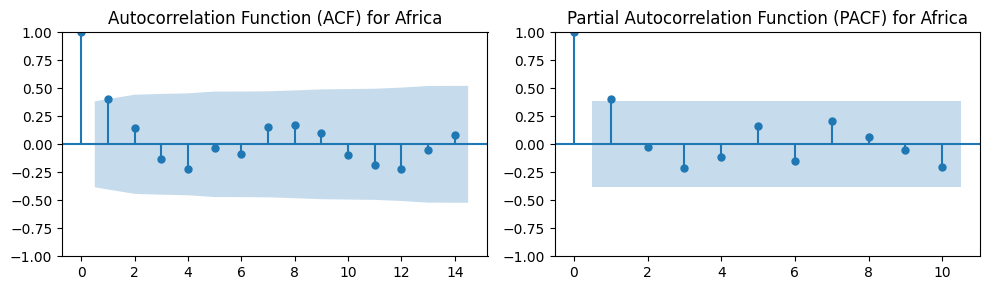

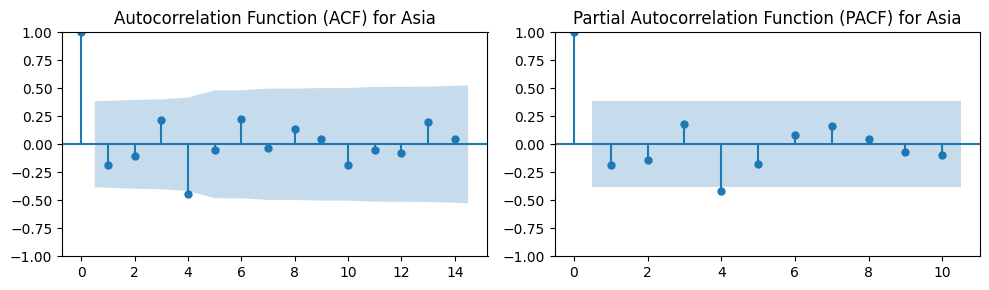

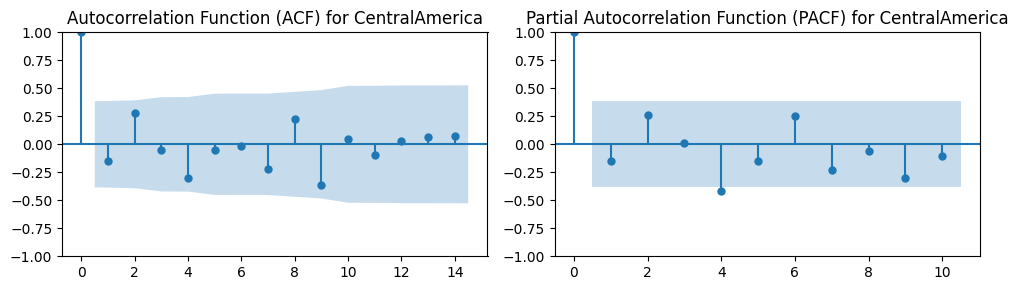

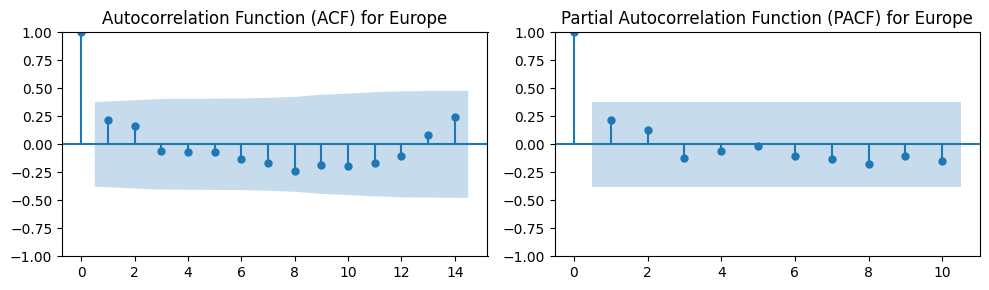

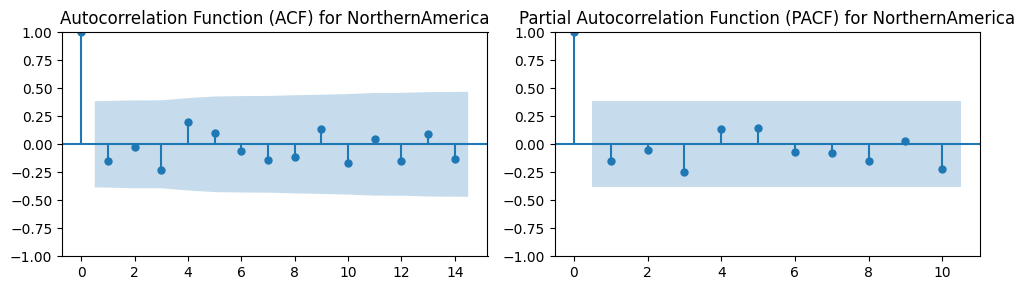

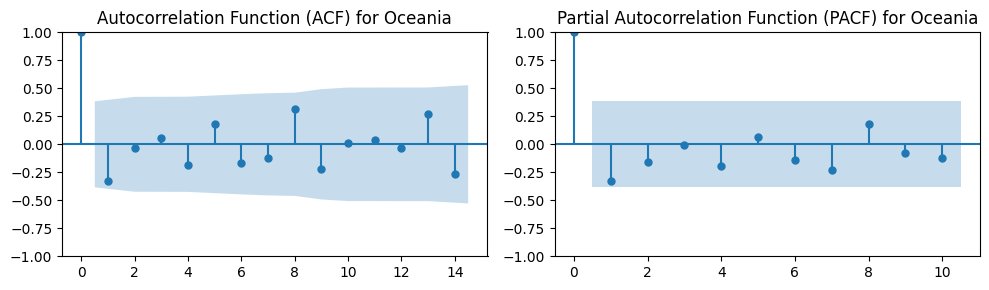

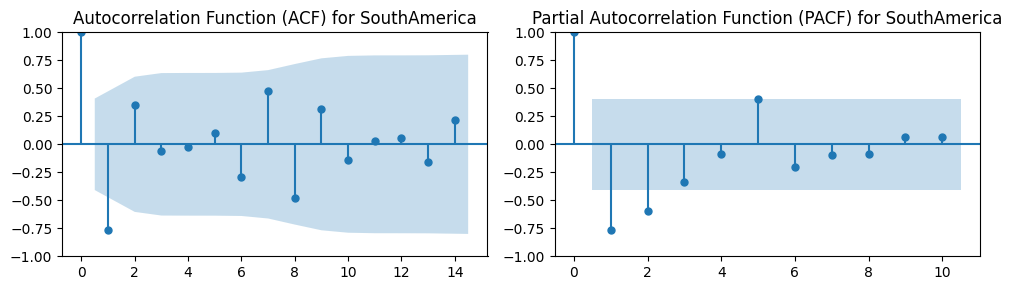

In [258]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    area = area.replace(" ", "")
    timeseries = traindfs[i]["Value"]
    x = ds[i]
    while x > 0:
        timeseries = timeseries.diff().dropna()
        x -= 1
    plottimeseries2(timeseries, area)
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Output_27_after_d/"+area+".csv")

In [443]:
# africa best value 10,1
# asia best value 13, 4
# europe is chosen 1,8
# na is chosen 3,3
# oceania best value 1,0
ps = [10,13,4,1,3,1,2]
qs = [1,4,9,8,3,0,8]

In [444]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

forecasts = []
for i in range(len(ps)):
    continent = traindfs[i]["Value"].tolist()
    model = ARIMA(continent, order = (ps[i],ds[i],qs[i]))
    model_fit = model.fit()
    continent_test = testdfs[i]["Value"]
    forecast_test = model_fit.forecast(len(continent_test))
    #print(forecast_test)
    forecasts.append(forecast_test)

In [445]:
ground_truths = []
for i in range(len(testdfs)):
    ground_truths.append(testdfs[i]["Value"].tolist())

In [446]:
import matplotlib.pyplot as plt

def plot_time_series_with_forecast2(original_series, ground_truth, predicted_value, area_name):

    # Create a list of years from 1990 to 2021
    years = list(range(1990, 2022))  # This will give you the years 1990 to 2021 (32 years)
    
    plt.figure(figsize=(10, 6))

    # Plot original time series (first 31 points)
    plt.plot(years[:27], original_series, label='Original Series', marker='o')

    # Plot the ground truth for the 32nd time step (year 2021)
    plt.plot(years[27:], ground_truth, label='Ground Truth (2017-2021)', color='green', marker='o')

    # Plot the predicted value for the 32nd time step (year 2021)
    plt.plot(years[27:], predicted_value, label='Predicted (2017-2021)', color='red', marker='x')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title(f'Time Series with Ground Truth and Prediction: {area_name}')
    plt.legend()

    # Show the plot
    plt.show()

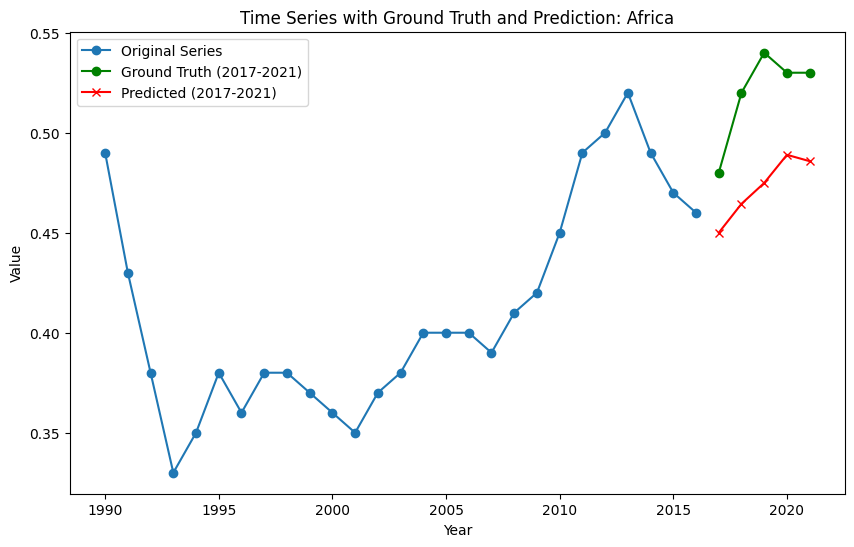

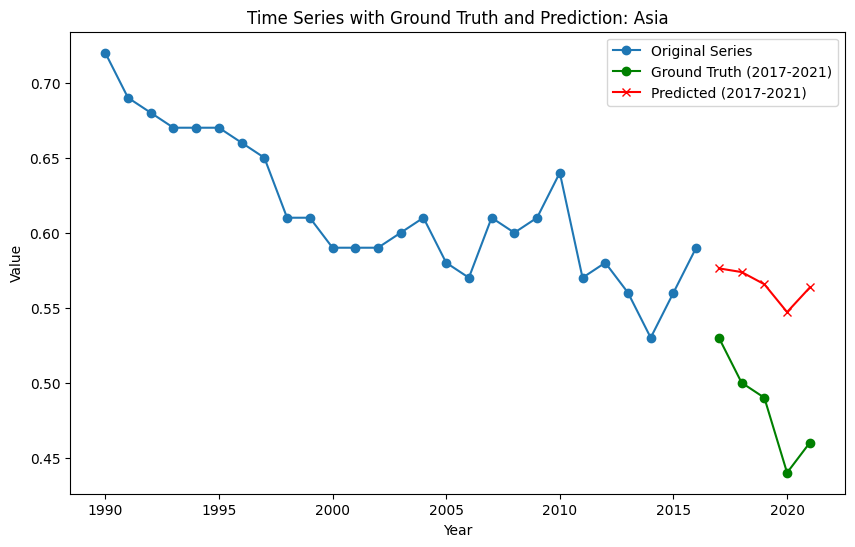

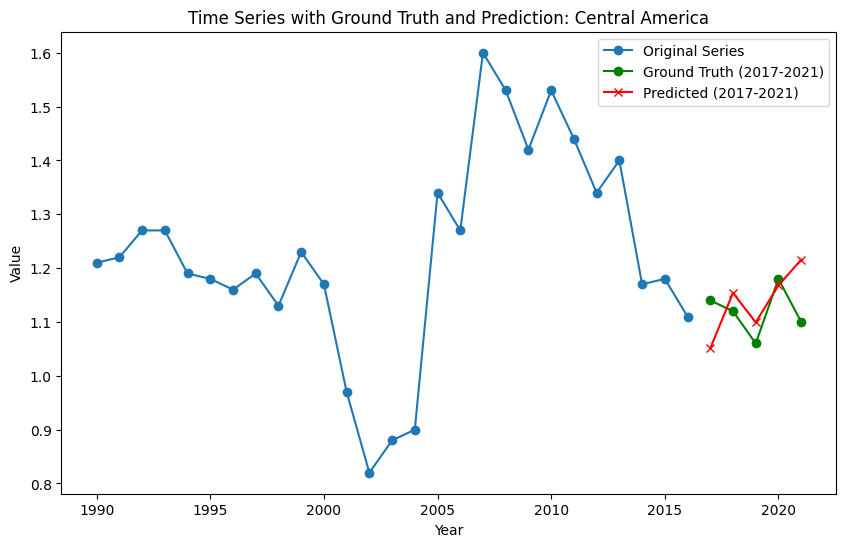

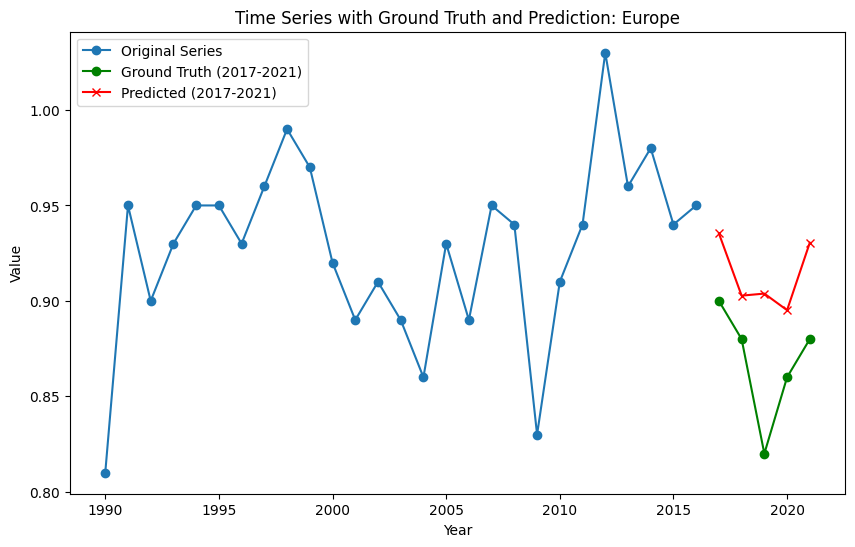

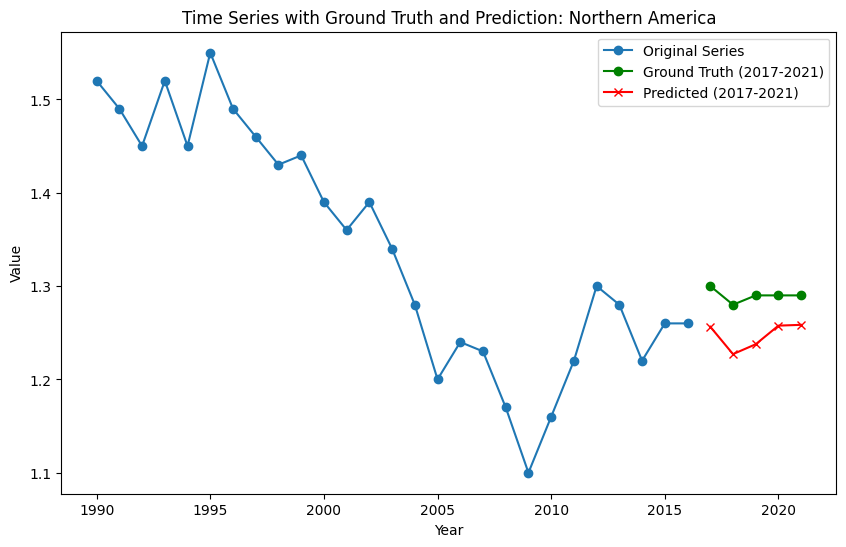

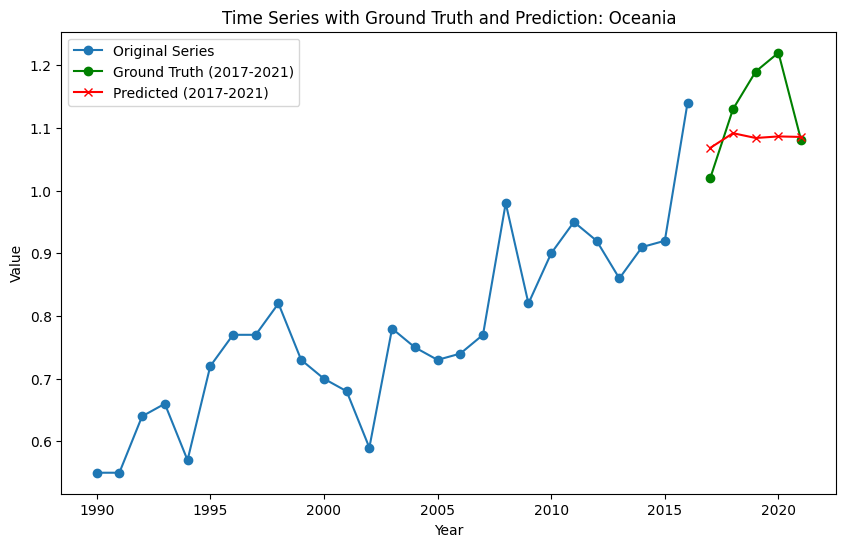

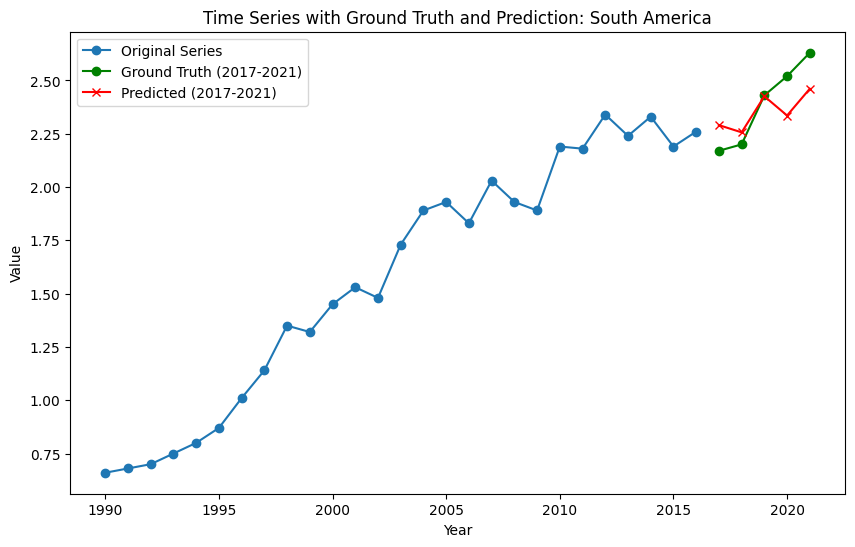

In [447]:
for i in range(len(traindfs)):
    original_series = traindfs[i]["Value"].tolist()
    ground_truth = ground_truths[i]
    predicted_value = forecasts[i]
    area = traindfs[i]["Area"].unique()[0]
    plot_time_series_with_forecast2(original_series, ground_truth, predicted_value, area)

In [448]:
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean(np.square(np.array(actual) - np.array(predicted))))

In [449]:
rmses = []
for i in range(len(ground_truths)):
    rmse = calculate_rmse(ground_truths[i], forecasts[i])
    rmse = round(rmse,4)
    rmses.append(rmse)

In [450]:
mean = sum(rmses)/len(rmses)

In [451]:
mean

0.072

In [452]:
df = pd.DataFrame({
    'Area': areas,
    'RMSE': rmses
})

In [453]:
df

,Area,RMSE
0,Africa,0.0487
1,Asia,0.0842
2,Central America,0.0696
3,Europe,0.0502
4,Northern America,0.0435
5,Oceania,0.0811
6,South America,0.1267
